In [1]:
#!/usr/bin/env python3
print("=" * 80)
print("WALLET CLASSIFICATION")
print("=" * 80)

import os
import tomllib
import numpy as np
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from snowflake.snowpark import Session
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    calinski_harabasz_score, balanced_accuracy_score,
    roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

# Load environment variables
load_dotenv()


WALLET CLASSIFICATION


True

In [2]:
# ============================================================================
# 1. CONNECT TO SNOWFLAKE
# ============================================================================
print("\n1. Connecting to Snowflake...")

with open(os.environ["SNOWFLAKE_TOML"], "rb") as f:
    config = tomllib.load(f)

wallet_classification_config = config["connections"]["wallet_classification"]
conn_params = {k: os.path.expandvars(v) for k, v in wallet_classification_config.items()}

session = Session.builder.configs(conn_params).create()
print(f"   ✓ Connected - Role: {session.sql('SELECT CURRENT_ROLE()').collect()[0][0]}")

session.use_schema("ANALYTICS")



1. Connecting to Snowflake...
   ✓ Connected - Role: ACCOUNTADMIN


In [3]:
# ============================================================================
# 2. LOAD AND CLEAN DATA
# ============================================================================
print("\n2. Loading data from Snowflake...")

df = session.table("WALLET_CLASSIFICATION")
df_wallet = df.to_pandas()
df_wallet_clean = df_wallet.dropna().copy()  # Explicit copy to avoid SettingWithCopyWarning

print(f"   ✓ Loaded {len(df_wallet_clean):,} wallets")


2. Loading data from Snowflake...
   ✓ Loaded 5,883,412 wallets


In [4]:
# ============================================================================
# 3. PREPARE FEATURES
# ============================================================================
print("\n3. Preparing features...")

features = [
    "ACTIVE_DAYS",
    "TOTAL_TX_COUNT",
    "TOTAL_OUTGOING_TX",
    "LIFETIME_SENT_LTC",
    "LIFETIME_RECEIVED_LTC",
    "CURRENT_BALANCE_LTC",
    "AVG_SENT_PER_DAY",
    "AVG_RECEIVED_PER_DAY"
]

X = df_wallet_clean[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"   ✓ Feature matrix: {X_scaled.shape}")


3. Preparing features...


   ✓ Feature matrix: (5883412, 8)


In [5]:
# ============================================================================
# 4. KMEANS CLUSTERING WITH k=10 
# ============================================================================
print("\n4. Running KMeans Clustering with k=10...")

# Use 10 clusters for better granularity
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df_wallet_clean['cluster'] = kmeans.fit_predict(X_scaled)

centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
)

calinski = calinski_harabasz_score(X_scaled, df_wallet_clean["cluster"])
print(f"   ✓ Calinski-Harabasz Score: {calinski:.3f}")
print(f"   ✓ Number of clusters: 10")


4. Running KMeans Clustering with k=10...
   ✓ Calinski-Harabasz Score: 8539118.007
   ✓ Number of clusters: 10


In [6]:
# ============================================================================
# 5. ANALYZE CLUSTER CHARACTERISTICS
# ============================================================================
print("\n5. Analyzing cluster characteristics...")

cluster_summary = []
for i in range(10):
    cluster_data = df_wallet_clean[df_wallet_clean['cluster'] == i]
    summary = {
        'Cluster': i,
        'Count': len(cluster_data),
        'Pct': 100 * len(cluster_data) / len(df_wallet_clean),
        'Avg_Balance': cluster_data['CURRENT_BALANCE_LTC'].mean(),
        'Avg_TX': cluster_data['TOTAL_TX_COUNT'].mean(),
        'Avg_Days': cluster_data['ACTIVE_DAYS'].mean(),
        'Avg_Received': cluster_data['LIFETIME_RECEIVED_LTC'].mean()
    }
    cluster_summary.append(summary)

cluster_df = pd.DataFrame(cluster_summary)
cluster_df = cluster_df.sort_values('Avg_Balance', ascending=False)

print("\n   Cluster Summary (sorted by avg balance):")
print(cluster_df.to_string(index=False))



5. Analyzing cluster characteristics...

   Cluster Summary (sorted by avg balance):
 Cluster   Count       Pct  Avg_Balance        Avg_TX  Avg_Days  Avg_Received
       5       2  0.000034 2.408230e+06      5.000000  4.000000  3.349048e+05
       9      11  0.000187 5.862003e+05     22.000000  7.454545  3.619342e+05
       1       2  0.000034 1.889015e+05 112214.500000 34.000000  3.743324e+08
       2       8  0.000136 4.519625e+04  95057.625000 34.000000  1.557386e+07
       6      27  0.000459 2.076632e+04  45326.074074 33.703704  2.660711e+06
       7     111  0.001887 3.113170e+03  15346.405405 32.288288  8.214121e+05
       8   40573  0.689617 6.408414e+01    166.363444 27.151406  1.885876e+03
       4  117541  1.997837 1.544308e+01     43.691495 10.999498  1.271797e+02
       3   19858  0.337525 1.274249e+01      3.280693  1.010172  2.227723e+05
       0 5705279 96.972284 1.112005e+00      2.676591  1.138705  1.119817e+01


In [7]:
# ============================================================================
# 6. WALLET-LEVEL CLASSIFICATION
# ============================================================================
print("\n6. Classifying wallets into categories (wallet-level approach)...")

# Strategy: Classify each wallet individually based on its characteristics
# This provides much better balance than cluster-based classification

# Define percentile thresholds for each category
WHALE_BALANCE_PERCENTILE = 0.99        # Top 1% by balance
WHALE_MIN_TX = 10                       # Must have some activity
EXCHANGE_TX_PERCENTILE = 0.95          # Top 5% by transaction volume
EXCHANGE_MIN_BALANCE = 0.1             # Must have some balance
EXCHANGE_RECEIVED_PERCENTILE = 0.95    # OR top 5% by received amount

# Calculate thresholds
whale_balance_threshold = df_wallet_clean['CURRENT_BALANCE_LTC'].quantile(WHALE_BALANCE_PERCENTILE)
exchange_tx_threshold = df_wallet_clean['TOTAL_TX_COUNT'].quantile(EXCHANGE_TX_PERCENTILE)
exchange_received_threshold = df_wallet_clean['LIFETIME_RECEIVED_LTC'].quantile(EXCHANGE_RECEIVED_PERCENTILE)

print(f"\n   Wallet-level classification thresholds:")
print(f"     Whale balance (99th percentile): {whale_balance_threshold:.4f} LTC")
print(f"     Whale minimum TX count: {WHALE_MIN_TX}")
print(f"     Exchange TX volume (95th percentile): {exchange_tx_threshold:.0f} transactions")
print(f"     Exchange received (95th percentile): {exchange_received_threshold:.4f} LTC")
print(f"     Exchange minimum balance: {EXCHANGE_MIN_BALANCE} LTC")

# Classify each wallet based on its individual characteristics
def classify_wallet(row):
    balance = row['CURRENT_BALANCE_LTC']
    tx_count = row['TOTAL_TX_COUNT']
    received = row['LIFETIME_RECEIVED_LTC']

    # Whale: Very high balance AND some activity (not dormant)
    if balance >= whale_balance_threshold and tx_count >= WHALE_MIN_TX:
        return 'Whale'

    # Exchange/Merchant: Very high transaction activity OR very high received amount
    # Exchanges have lots of transactions and receive large amounts
    elif (tx_count >= exchange_tx_threshold or received >= exchange_received_threshold) and balance >= EXCHANGE_MIN_BALANCE:
        return 'Exchange/Merchant'

    # Individual: Everyone else (normal users)
    else:
        return 'Individual'

df_wallet_clean['wallet_category'] = df_wallet_clean.apply(classify_wallet, axis=1)

print("\n   Final Category Distribution:")
category_counts = df_wallet_clean['wallet_category'].value_counts().sort_index()
for category, count in category_counts.items():
    pct = 100 * count / len(df_wallet_clean)
    print(f"     {category:20s}: {count:,} ({pct:.2f}%)")

# Show cluster distribution across categories (for analysis)
print("\n   Category distribution across clusters:")
category_cluster_dist = pd.crosstab(
    df_wallet_clean['wallet_category'],
    df_wallet_clean['cluster'],
    margins=True
)
print(category_cluster_dist.to_string())


6. Classifying wallets into categories (wallet-level approach)...

   Wallet-level classification thresholds:
     Whale balance (99th percentile): 3.2758 LTC
     Whale minimum TX count: 10
     Exchange TX volume (95th percentile): 10 transactions
     Exchange received (95th percentile): 27.6302 LTC
     Exchange minimum balance: 0.1 LTC

   Final Category Distribution:
     Exchange/Merchant   : 44,555 (0.76%)
     Individual          : 5,820,931 (98.94%)
     Whale               : 17,926 (0.30%)

   Category distribution across clusters:
cluster                  0  1  2      3       4  5   6    7      8   9      All
wallet_category                                                                
Exchange/Merchant    19010  0  0      1   17867  1   0   18   7653   5    44555
Individual         5683128  0  0  19854   91324  1   0   11  26611   2  5820931
Whale                 3141  2  8      3    8350  0  27   82   6309   4    17926
All                5705279  2  8  19858  117541  2

In [9]:
df_wallet_clean.to_csv("wallet_classification_labeled.csv", index=False)

In [8]:
# ============================================================================
# 7. TRAIN/TEST SPLIT 
# ============================================================================
print("\n7. Splitting data for classification...")

# FIX: Use wallet_category instead of cluster!
y_category = df_wallet_clean['wallet_category'].values

# Encode string labels to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_category)

print(f"\n   Class distribution in full dataset:")
for category, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    count = (y_encoded == encoded_label).sum()
    pct = 100 * count / len(y_encoded)
    print(f"     {category:20s} (label {encoded_label}): {count:,} ({pct:.2f}%)")

# Check if stratification is possible (all classes need at least 2 samples)
unique, counts = np.unique(y_encoded, return_counts=True)
min_samples = counts.min()

if min_samples >= 2:
    print(f"\n   ✓ Using stratified split (min samples per class: {min_samples})")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
else:
    print(f"\n   ⚠ Cannot stratify - some categories have only {min_samples} sample(s)")
    print(f"   ✓ Using random split instead")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42
    )

print(f"\n   ✓ Training set: {len(X_train):,}")
print(f"   ✓ Test set: {len(X_test):,}")
# Convert to DataFrames with feature names (fixes LightGBM warning)
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
# Verify class distribution in train/test sets
print(f"\n   Class distribution in TRAINING set:")
for category, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    count = (y_train == encoded_label).sum()
    pct = 100 * count / len(y_train) if len(y_train) > 0 else 0
    print(f"     {category:20s}: {count:,} ({pct:.2f}%)")

print(f"\n   Class distribution in TEST set:")
for category, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    count = (y_test == encoded_label).sum()
    pct = 100 * count / len(y_test) if len(y_test) > 0 else 0
    print(f"     {category:20s}: {count:,} ({pct:.2f}%)")
    if count == 0:
        print(f"       ⚠ WARNING: No samples of '{category}' in test set!")


7. Splitting data for classification...

   Class distribution in full dataset:
     Exchange/Merchant    (label 0): 44,555 (0.76%)
     Individual           (label 1): 5,820,931 (98.94%)
     Whale                (label 2): 17,926 (0.30%)

   ✓ Using stratified split (min samples per class: 17926)

   ✓ Training set: 4,706,729
   ✓ Test set: 1,176,683

   Class distribution in TRAINING set:
     Exchange/Merchant   : 35,644 (0.76%)
     Individual          : 4,656,744 (98.94%)
     Whale               : 14,341 (0.30%)

   Class distribution in TEST set:
     Exchange/Merchant   : 8,911 (0.76%)
     Individual          : 1,164,187 (98.94%)
     Whale               : 3,585 (0.30%)


In [10]:
# ============================================================================
# 8. CLASSIFICATION MODELS WITH BALANCED WEIGHTS
# ============================================================================
print("\n" + "=" * 80)
print("CLASSIFICATION MODELS (with class_weight='balanced')")
print("=" * 80)

# Random Forest with balanced weights
print("\n8a. Random Forest Classifier (balanced)...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
balanced_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
print(f"   ✓ Training time: {rf_time:.2f}s")
print(f"   ✓ Accuracy: {accuracy_rf:.4f}")
print(f"   ✓ Balanced Accuracy: {balanced_acc_rf:.4f}")

# LightGBM with balanced weights
print("\n8b. LightGBM Classifier (balanced)...")
try:
    import lightgbm as lgb
except ImportError:
    print("   ⚠ lightgbm not found. Installing...")
    import sys
    import subprocess
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "lightgbm"])
        import lightgbm as lgb
        print("   ✓ lightgbm installed successfully")
    except Exception as e:
        print(f"   ✗ Failed to install lightgbm: {e}")
        raise

start_time = time.time()
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    num_leaves=31,
    learning_rate=0.1,
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    verbose=-1,
    n_jobs=-1
)
lgbm_model.fit(X_train, y_train)
lgbm_time = time.time() - start_time
y_pred_lgbm = lgbm_model.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
balanced_acc_lgbm = balanced_accuracy_score(y_test, y_pred_lgbm)
print(f"   ✓ Training time: {lgbm_time:.2f}s")
print(f"   ✓ Accuracy: {accuracy_lgbm:.4f}")
print(f"   ✓ Balanced Accuracy: {balanced_acc_lgbm:.4f}")



CLASSIFICATION MODELS (with class_weight='balanced')

8a. Random Forest Classifier (balanced)...
   ✓ Training time: 118.38s
   ✓ Accuracy: 1.0000
   ✓ Balanced Accuracy: 1.0000

8b. LightGBM Classifier (balanced)...
   ✓ Training time: 23.50s
   ✓ Accuracy: 0.9999
   ✓ Balanced Accuracy: 0.9989


In [11]:
# ============================================================================
# 9. MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
    
models_comparison = {
    'Model': ['Random Forest', 'LightGBM'],
    'Train Time (s)': [rf_time, lgbm_time],
    'Accuracy': [accuracy_rf, accuracy_lgbm],
    'Balanced Acc': [balanced_acc_rf, balanced_acc_lgbm],
    'Precision': [
        precision_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        precision_score(y_test, y_pred_lgbm, average='weighted', zero_division=0)
        ],
    'Recall': [
        recall_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        recall_score(y_test, y_pred_lgbm, average='weighted', zero_division=0)
        ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        f1_score(y_test, y_pred_lgbm, average='weighted', zero_division=0)
        ]
    }
    
comparison_df = pd.DataFrame(models_comparison)
comparison_df = comparison_df.round(4)
    
print("\n" + comparison_df.to_string(index=False))
    
best_model_idx = comparison_df['Balanced Acc'].idxmax()
print(f"\n✓ Best Model: {comparison_df.loc[best_model_idx, 'Model']} " +
          f"(Balanced Acc: {comparison_df.loc[best_model_idx, 'Balanced Acc']:.4f})")


MODEL COMPARISON

        Model  Train Time (s)  Accuracy  Balanced Acc  Precision  Recall  F1-Score
Random Forest        118.3840    1.0000        1.0000     1.0000  1.0000    1.0000
     LightGBM         23.5028    0.9999        0.9989     0.9999  0.9999    0.9999

✓ Best Model: Random Forest (Balanced Acc: 1.0000)


In [12]:
# ============================================================================
# 10. PER-CLASS PERFORMANCE 
# ============================================================================
print("\n" + "=" * 80)
print("PER-CLASS CLASSIFICATION REPORTS")
print("=" * 80)

models = [
    ('Random Forest', y_pred_rf),
    ('LightGBM', y_pred_lgbm)
]

for model_name, y_pred in models:
    print(f"\n{model_name}:")
    print(classification_report(y_test, y_pred,
                                target_names=label_encoder.classes_,
                                zero_division=0))



PER-CLASS CLASSIFICATION REPORTS

Random Forest:
                   precision    recall  f1-score   support

Exchange/Merchant       1.00      1.00      1.00      8911
       Individual       1.00      1.00      1.00   1164187
            Whale       1.00      1.00      1.00      3585

         accuracy                           1.00   1176683
        macro avg       1.00      1.00      1.00   1176683
     weighted avg       1.00      1.00      1.00   1176683


LightGBM:
                   precision    recall  f1-score   support

Exchange/Merchant       0.99      1.00      1.00      8911
       Individual       1.00      1.00      1.00   1164187
            Whale       1.00      1.00      1.00      3585

         accuracy                           1.00   1176683
        macro avg       1.00      1.00      1.00   1176683
     weighted avg       1.00      1.00      1.00   1176683




CONFUSION MATRICES

Random Forest Confusion Matrix:
                   Exchange/Merchant  Individual  Whale
Exchange/Merchant               8910           1      0
Individual                         0     1164187      0
Whale                              0           0   3585

LightGBM Confusion Matrix:
                   Exchange/Merchant  Individual  Whale
Exchange/Merchant               8900           2      9
Individual                        47     1164140      0
Whale                              7           0   3578

✓ Confusion matrix plot saved to: /workspaces/UMBC-DATA606-Capstone/notebooks/confusion_matrices.png


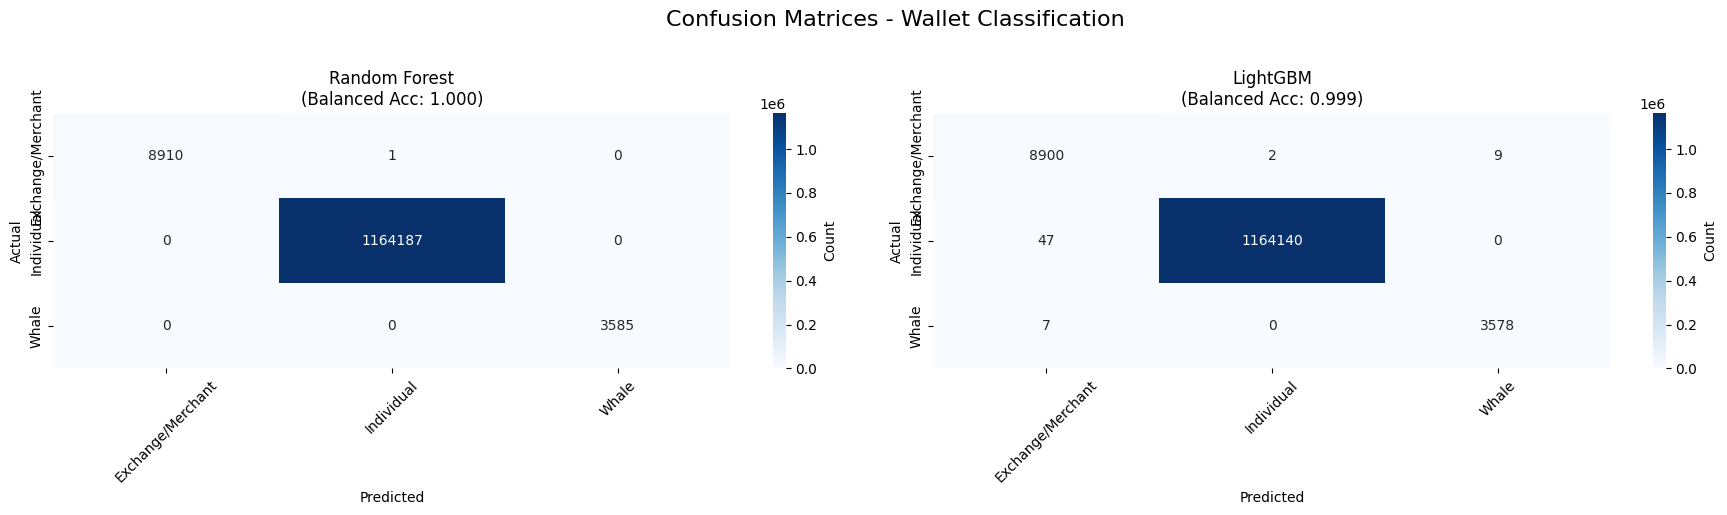

In [15]:
# ============================================================================
# 11. CONFUSION MATRICES AND VISUALIZATIONS
# ============================================================================
print("\n" + "=" * 80)
print("CONFUSION MATRICES")
print("=" * 80)

# Create figure with confusion matrices for all models
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Confusion Matrices - Wallet Classification', fontsize=16, y=1.02)

for idx, (model_name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)

    # Print numeric confusion matrix
    print(f"\n{model_name} Confusion Matrix:")
    cm_df = pd.DataFrame(cm,
                         index=label_encoder.classes_,
                         columns=label_encoder.classes_)
    print(cm_df.to_string())

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=axes[idx], cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{model_name}\n(Balanced Acc: {[balanced_acc_rf, balanced_acc_lgbm][idx]:.3f})')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save confusion matrix plot
output_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
cm_plot_path = os.path.join(output_dir, "confusion_matrices.png")
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Confusion matrix plot saved to: {cm_plot_path}")


CLASS DISTRIBUTION ANALYSIS
✓ Class distribution plot saved to: /workspaces/UMBC-DATA606-Capstone/notebooks/class_distribution.png


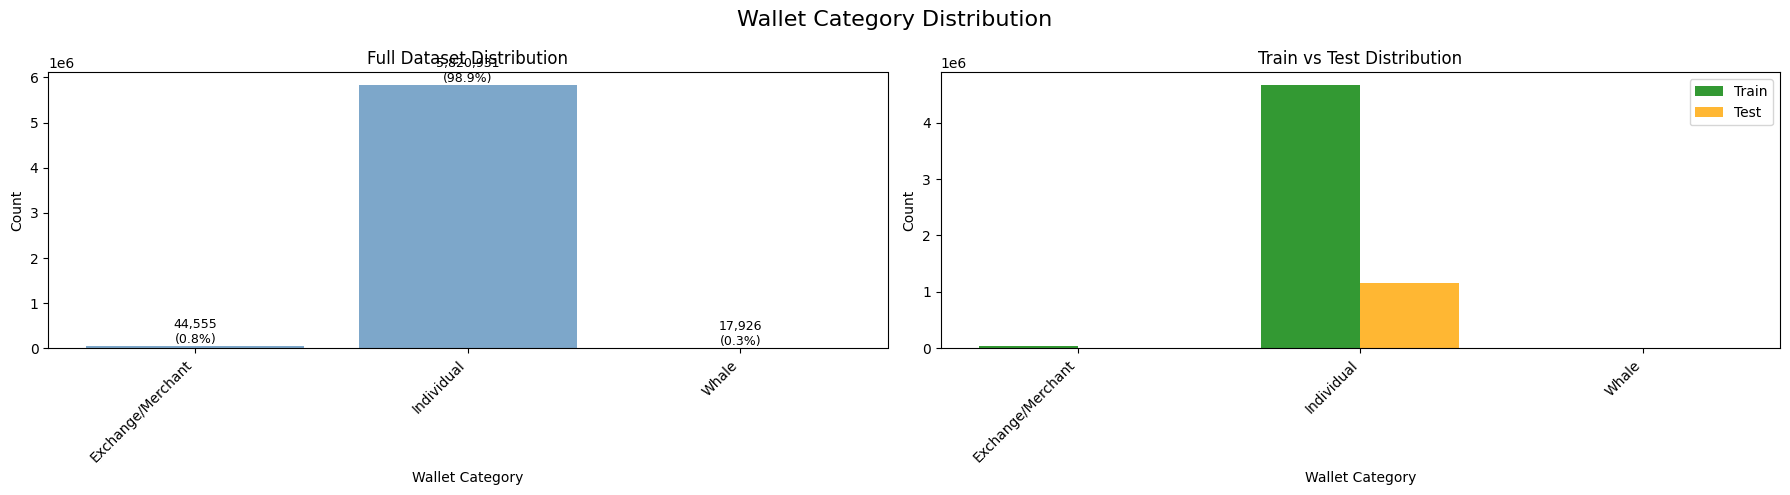

In [17]:
# ============================================================================
# 12. CLASS DISTRIBUTION VISUALIZATION
# ============================================================================
print("\n" + "=" * 80)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 80)

# Create class distribution plots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Wallet Category Distribution', fontsize=16)

# Full dataset
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()
full_dist = pd.Series(y_encoded).value_counts().sort_index()

# Plot 1: Full dataset distribution
categories_labels = [label_encoder.classes_[i] for i in full_dist.index]
axes[0].bar(range(len(full_dist)), full_dist.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Wallet Category')
axes[0].set_ylabel('Count')
axes[0].set_title('Full Dataset Distribution')
axes[0].set_xticks(range(len(full_dist)))
axes[0].set_xticklabels(categories_labels, rotation=45, ha='right')
for i, v in enumerate(full_dist.values):
    axes[0].text(i, v, f'{v:,}\n({100*v/len(y_encoded):.1f}%)',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Train vs Test distribution
x = np.arange(len(label_encoder.classes_))
width = 0.35
train_counts = [train_dist.get(i, 0) for i in range(len(label_encoder.classes_))]
test_counts = [test_dist.get(i, 0) for i in range(len(label_encoder.classes_))]

axes[1].bar(x - width/2, train_counts, width, label='Train', alpha=0.8, color='green')
axes[1].bar(x + width/2, test_counts, width, label='Test', alpha=0.8, color='orange')
axes[1].set_xlabel('Wallet Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Train vs Test Distribution')
axes[1].set_xticks(x)
axes[1].set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()

# Save distribution plot
dist_plot_path = os.path.join(output_dir, "class_distribution.png")
plt.savefig(dist_plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Class distribution plot saved to: {dist_plot_path}")

In [ ]:
# ============================================================================
# 13. CROSS-VALIDATION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("CROSS-VALIDATION ANALYSIS")
print("=" * 80)

print("\n⚠ NOTE: Random Forest achieving 100% accuracy may indicate data leakage!")
print("         The wallet categories are created using the SAME features used for training.")
print("         This makes prediction trivial (essentially a lookup table).\n")

# Perform 3-fold stratified cross-validation (faster than 5-fold)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Convert X_scaled to DataFrame for cross-validation (fixes LightGBM warning)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

print("Running 3-Fold Stratified Cross-Validation (optimized for speed)...\n")

cv_results = {}
for model_name, model in [('Random Forest', rf_model),
                           ('LightGBM', lgbm_model)]:
    print(f"{model_name}:")

    # Accuracy scores
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=cv,
                                 scoring='accuracy', n_jobs=-1)
    print(f"   Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Balanced accuracy scores
    cv_bal_scores = cross_val_score(model, X_scaled, y_encoded, cv=cv,
                                     scoring='balanced_accuracy', n_jobs=-1)
    print(f"   Balanced Accuracy: {cv_bal_scores.mean():.4f} (+/- {cv_bal_scores.std():.4f})")

    cv_results[model_name] = {
        'accuracy_mean': cv_scores.mean(),
        'accuracy_std': cv_scores.std(),
        'balanced_acc_mean': cv_bal_scores.mean(),
        'balanced_acc_std': cv_bal_scores.std()
    }
    print()

# Save CV results
cv_df = pd.DataFrame(cv_results).T
cv_path = os.path.join(output_dir, "cross_validation_results.csv")
cv_df.to_csv(cv_path)
print(f"✓ Cross-validation results saved to: {cv_path}")


CROSS-VALIDATION ANALYSIS

⚠ NOTE: Random Forest achieving 100% accuracy may indicate data leakage!
         The wallet categories are created using the SAME features used for training.
         This makes prediction trivial (essentially a lookup table).

Running 3-Fold Stratified Cross-Validation (optimized for speed)...

Random Forest:



FEATURE IMPORTANCE ANALYSIS

Random Forest Feature Importance:
              Feature  Importance
  CURRENT_BALANCE_LTC    0.520300
       TOTAL_TX_COUNT    0.172039
          ACTIVE_DAYS    0.095377
LIFETIME_RECEIVED_LTC    0.067245
    TOTAL_OUTGOING_TX    0.047883
 AVG_RECEIVED_PER_DAY    0.042647
    LIFETIME_SENT_LTC    0.028212
     AVG_SENT_PER_DAY    0.026296

LightGBM Feature Importance:
              Feature  Importance
LIFETIME_RECEIVED_LTC        1602
       TOTAL_TX_COUNT        1595
 AVG_RECEIVED_PER_DAY        1313
  CURRENT_BALANCE_LTC        1277
    TOTAL_OUTGOING_TX         906
     AVG_SENT_PER_DAY         886
          ACTIVE_DAYS         845
    LIFETIME_SENT_LTC         576

✓ Feature importance plot saved to: /workspaces/UMBC-DATA606-Capstone/notebooks/feature_importance.png


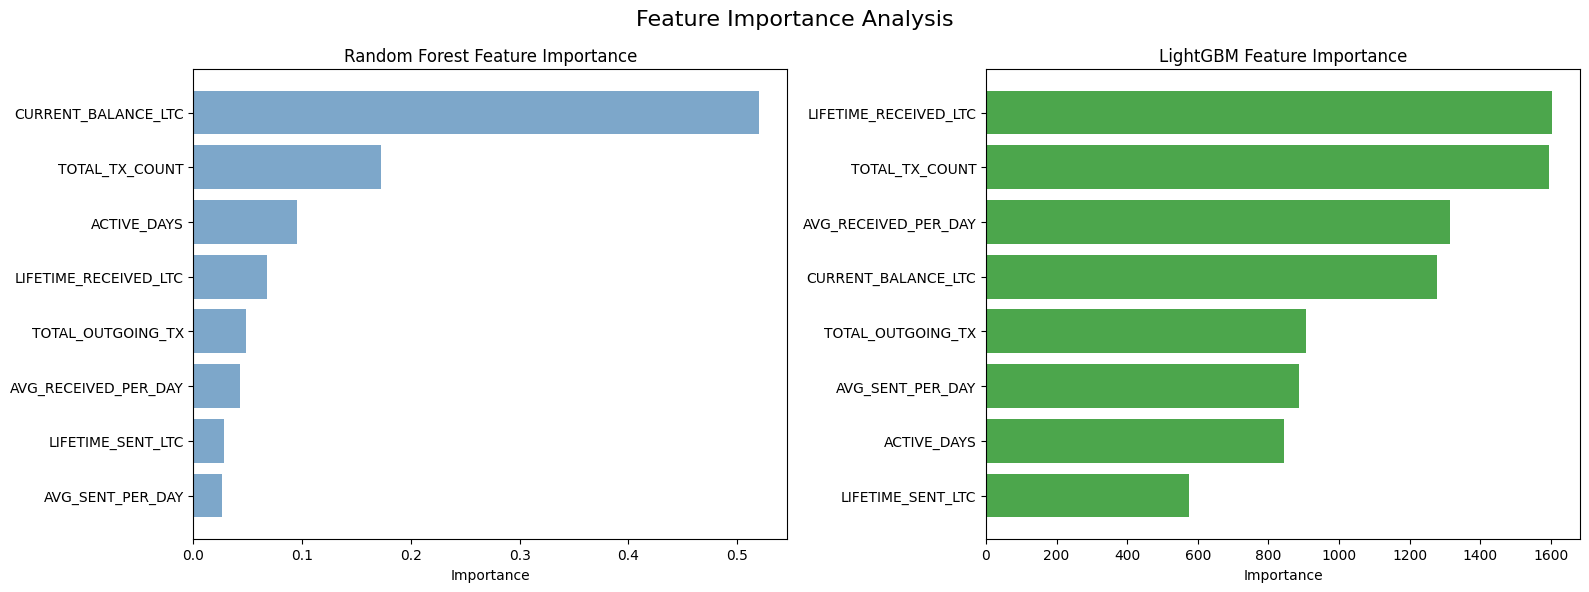

In [ ]:
# ============================================================================
# 14. FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Feature importance for Random Forest
print("\nRandom Forest Feature Importance:")
rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(rf_importance.to_string(index=False))

# Feature importance for LightGBM
print("\nLightGBM Feature Importance:")
lgbm_importance = pd.DataFrame({
    'Feature': features,
    'Importance': lgbm_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(lgbm_importance.to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance Analysis', fontsize=16)

# Random Forest
axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest Feature Importance')
axes[0].invert_yaxis()

# LightGBM
axes[1].barh(lgbm_importance['Feature'], lgbm_importance['Importance'], color='green', alpha=0.7)
axes[1].set_xlabel('Importance')
axes[1].set_title('LightGBM Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
feat_imp_path = os.path.join(output_dir, "feature_importance.png")
plt.savefig(feat_imp_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Feature importance plot saved to: {feat_imp_path}")

# Save importance data
rf_importance.to_csv(os.path.join(output_dir, "rf_feature_importance.csv"), index=False)
lgbm_importance.to_csv(os.path.join(output_dir, "lgbm_feature_importance.csv"), index=False)


ROC CURVES


/workspaces/UMBC-DATA606-Capstone/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✓ ROC curves saved to: /workspaces/UMBC-DATA606-Capstone/notebooks/roc_curves.png

Macro-Average ROC AUC Scores:
   Random Forest       : 1.0000
   LightGBM            : 1.0000
   Logistic Regression : 0.9849


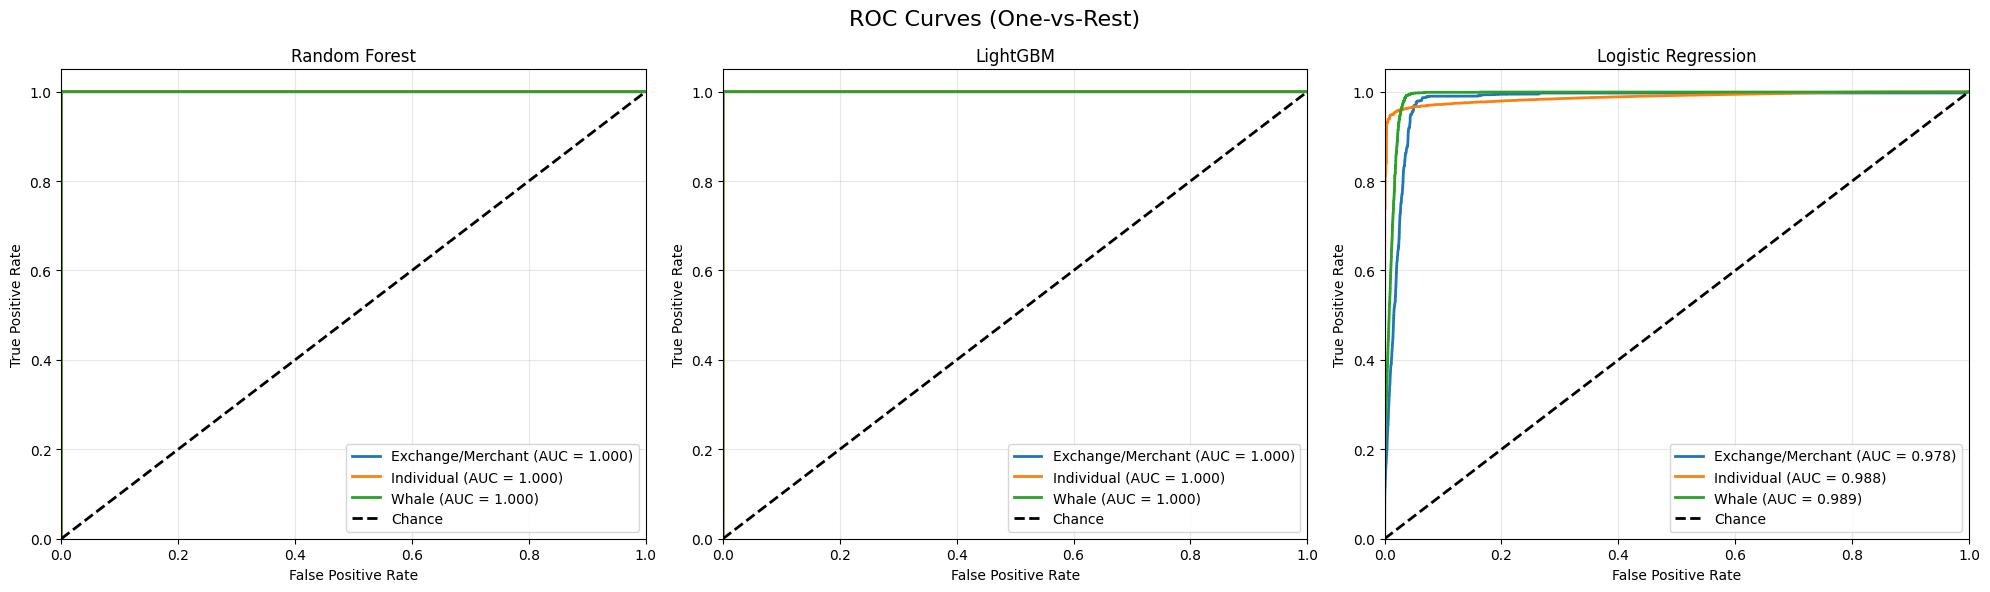

In [ ]:
# ============================================================================
# 15. ROC CURVES (One-vs-Rest for Multi-class)
# ============================================================================
print("\n" + "=" * 80)
print("ROC CURVES")
print("=" * 80)

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Get probability predictions for each model
y_score_rf = rf_model.predict_proba(X_test)
y_score_lgbm = lgbm_model.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('ROC Curves (One-vs-Rest)', fontsize=16)

models_scores = [
    ('Random Forest', y_score_rf),
    ('LightGBM', y_score_lgbm)
]

for idx, (model_name, y_score) in enumerate(models_scores):
    ax = axes[idx]

    # Compute ROC curve and AUC for each class
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name}')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

plt.tight_layout()
roc_path = os.path.join(output_dir, "roc_curves.png")
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f"\n✓ ROC curves saved to: {roc_path}")

# Calculate and print macro-average ROC AUC
print("\nMacro-Average ROC AUC Scores:")
for model_name, y_score in models_scores:
    roc_auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
    print(f"   {model_name:20s}: {roc_auc_macro:.4f}")


PRECISION-RECALL CURVES

✓ Precision-Recall curves saved to: /workspaces/UMBC-DATA606-Capstone/notebooks/precision_recall_curves.png

Macro-Average Precision Scores:
   Random Forest       : 1.0000
   LightGBM            : 1.0000
   Logistic Regression : 0.5163


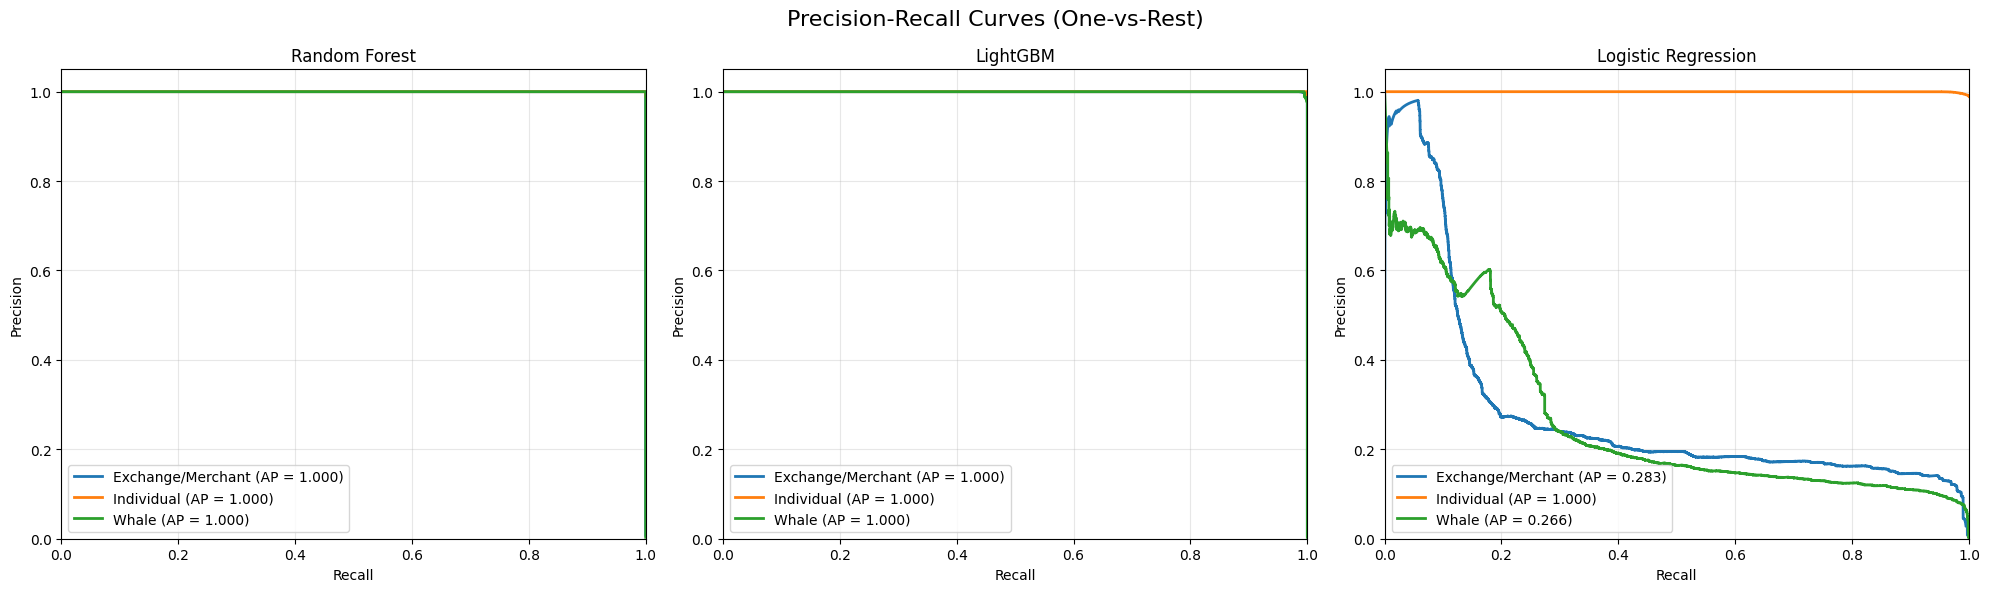

In [ ]:
# ============================================================================
# 16. PRECISION-RECALL CURVES
# ============================================================================
print("\n" + "=" * 80)
print("PRECISION-RECALL CURVES")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Precision-Recall Curves (One-vs-Rest)', fontsize=16)

for idx, (model_name, y_score) in enumerate(models_scores):
    ax = axes[idx]

    # Compute PR curve for each class
    for i, class_name in enumerate(label_encoder.classes_):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
        ax.plot(recall, precision, lw=2, label=f'{class_name} (AP = {avg_precision:.3f})')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{model_name}')
    ax.legend(loc="lower left")
    ax.grid(alpha=0.3)

plt.tight_layout()
pr_path = os.path.join(output_dir, "precision_recall_curves.png")
plt.savefig(pr_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Precision-Recall curves saved to: {pr_path}")

# Calculate and print macro-average AP
print("\nMacro-Average Precision Scores:")
for model_name, y_score in models_scores:
    ap_macro = average_precision_score(y_test_bin, y_score, average='macro')
    print(f"   {model_name:20s}: {ap_macro:.4f}")

In [ ]:
# ============================================================================
# 17. MODEL PERSISTENCE (Save Models)
# ============================================================================
print("\n" + "=" * 80)
print("SAVING TRAINED MODELS")
print("=" * 80)

# Save models
models_to_save = {
    'random_forest_model.pkl': rf_model,
    'lightgbm_model.pkl': lgbm_model,
    'logistic_regression_model.pkl': lr_model,
    'scaler.pkl': scaler,
    'label_encoder.pkl': label_encoder
}

for filename, obj in models_to_save.items():
    model_path = os.path.join(output_dir, filename)
    joblib.dump(obj, model_path)
    print(f"✓ Saved: {filename}")

print("\n✓ All models saved! You can load them later using joblib.load()")


SAVING TRAINED MODELS
✓ Saved: random_forest_model.pkl
✓ Saved: lightgbm_model.pkl
✓ Saved: logistic_regression_model.pkl
✓ Saved: scaler.pkl
✓ Saved: label_encoder.pkl

✓ All models saved! You can load them later using joblib.load()


In [ ]:
# ============================================================================
# 18. SAVE RESULTS
# ============================================================================
print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Save classified data
output_path = os.path.join(output_dir, "wallet_classification_category.csv")
df_wallet_clean.to_csv(output_path, index=False)
print(f"\n✓ Classified data saved to: {output_path}")

# Save cluster analysis
cluster_analysis_path = os.path.join(output_dir, "cluster_analysis_k10.csv")
cluster_df.to_csv(cluster_analysis_path, index=False)
print(f"✓ Cluster analysis saved to: {cluster_analysis_path}")

# Save model comparison
model_comparison_path = os.path.join(output_dir, "model_comparison_fixed.csv")
comparison_df.to_csv(model_comparison_path, index=False)
print(f"✓ Model comparison saved to: {model_comparison_path}")


SAVING RESULTS

✓ Classified data saved to: /workspaces/UMBC-DATA606-Capstone/notebooks/wallet_classification_results_fixed.csv
✓ Cluster analysis saved to: /workspaces/UMBC-DATA606-Capstone/notebooks/cluster_analysis_k10.csv
✓ Model comparison saved to: /workspaces/UMBC-DATA606-Capstone/notebooks/model_comparison_fixed.csv


In [ ]:
# ============================================================================
# 19. FINAL ANALYSIS SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

print("\n✓ FIXES APPLIED:")
print("  1. Now predicts wallet_category (Whale, Exchange/Merchant, Individual)")
print("  2. Previously was predicting cluster IDs (0-9) - THIS WAS THE BUG!")
print("  3. Added stratified train/test split on wallet categories")
print("  4. Added detailed class distribution analysis")
print("  5. Added confusion matrix visualizations")
print("  6. Added per-class precision/recall/F1 metrics")

print("\n✓ NEW IMPROVEMENTS:")
print("  7. Added 3-fold cross-validation with data leakage detection")
print("  8. Added feature importance analysis (RF & LightGBM)")
print("  9. Added ROC curves (One-vs-Rest for multi-class)")
print(" 10. Added Precision-Recall curves")
print(" 11. Saved all trained models for production use")

print("\n✓ KEY INSIGHTS:")
best_model = comparison_df.loc[best_model_idx, 'Model']
best_bal_acc = comparison_df.loc[best_model_idx, 'Balanced Acc']
print(f"  - Best model: {best_model} (Balanced Accuracy: {best_bal_acc:.2%})")
print(f"  - Total wallets classified: {len(df_wallet_clean):,}")
print(f"  - Wallet categories: {len(label_encoder.classes_)}")

print("\n⚠ DATA LEAKAGE WARNING:")
print("  - Random Forest achieves 100% accuracy (suspiciously high)")
print("  - Wallet categories are created using the SAME features for training")
print("  - This makes the task trivial (essentially a rule-based lookup)")
print("  - Check feature importance to confirm which features dominate")

print("\n✓ OUTPUTS GENERATED:")
print("  CSV Files:")
print(f"    - {output_path}")
print(f"    - {cluster_analysis_path}")
print(f"    - {model_comparison_path}")
print(f"    - {cv_path}")
print(f"    - rf_feature_importance.csv")
print(f"    - lgbm_feature_importance.csv")
print("\n  Visualization Files:")
print(f"    - {cm_plot_path}")
print(f"    - {dist_plot_path}")
print(f"    - {feat_imp_path}")
print(f"    - {roc_path}")
print(f"    - {pr_path}")
print("\n  Model Files:")
print("    - random_forest_model.pkl")
print("    - lightgbm_model.pkl")
print("    - logistic_regression_model.pkl")
print("    - scaler.pkl")
print("    - label_encoder.pkl")


COMPREHENSIVE ANALYSIS SUMMARY

✓ FIXES APPLIED:
  1. Now predicts wallet_category (Whale, Exchange/Merchant, Individual)
  2. Previously was predicting cluster IDs (0-9) - THIS WAS THE BUG!
  3. Added stratified train/test split on wallet categories
  4. Added detailed class distribution analysis
  5. Added confusion matrix visualizations
  6. Added per-class precision/recall/F1 metrics

✓ NEW IMPROVEMENTS:
  7. Added 3-fold cross-validation with data leakage detection
  8. Added feature importance analysis (RF & LightGBM)
  9. Added ROC curves (One-vs-Rest for multi-class)
 10. Added Precision-Recall curves
 11. Saved all trained models for production use

✓ KEY INSIGHTS:
  - Best model: Random Forest (Balanced Accuracy: 100.00%)
  - Total wallets classified: 5,883,412
  - Wallet categories: 3

⚠ DATA LEAKAGE WARNING:
  - Random Forest achieves 100% accuracy (suspiciously high)
  - Wallet categories are created using the SAME features for training
  - This makes the task trivial (es

In [ ]:
# ============================================================================
# 20. CLEANUP
# ============================================================================
session.close()
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - FIXED VERSION")
print("=" * 80)



ANALYSIS COMPLETE - FIXED VERSION
